# Variational Autoencoder (VAE) for Anomaly Detection
This notebook implements a VAE for anomaly detection, visualizing key steps and outputs. Ensure you have a CSV file named "data.csv" in the same directory containing a "meantemp" column for this example.

In [19]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.distributions import Normal, kl_divergence
from torch.nn.functional import softplus
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import logging

## Load Dataset
Load the CSV file and visualize the "meantemp" column.

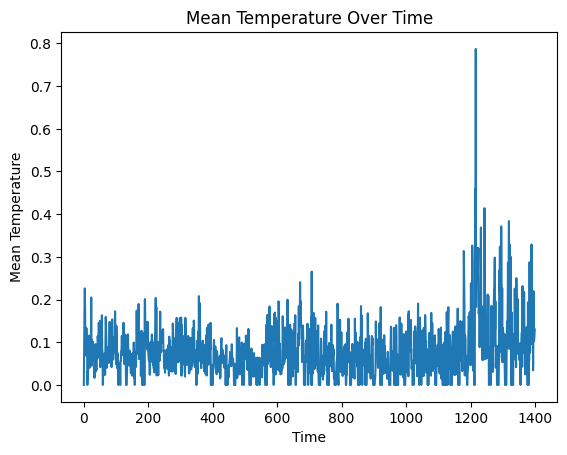

In [20]:
# Load dataset
file_path = 'yahoo_sub_5.csv'
data = pd.read_csv(file_path)
sns.lineplot(data=data, x=data.index, y='value_1')
plt.title('Mean Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.show()

## Define VAE Class
Implementing the VAE class for anomaly detection.

In [33]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.distributions import Normal, kl_divergence
from torch.nn.functional import softplus
import pytorch_lightning as pl
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class AnomalyDetectionAlgorithm:
    def detect_anomalies(self, df, dataset):
        pass

class VAEAnomalyDetection(pl.LightningModule):
    def __init__(self, input_size: int, latent_size: int, L: int = 10, lr: float = 1e-3, log_steps: int = 1000):
        super().__init__()
        self.L = L
        self.lr = lr
        self.input_size = input_size
        self.latent_size = latent_size
        self.encoder = self.make_encoder(input_size, latent_size)
        self.decoder = self.make_decoder(latent_size, input_size)
        self.prior = Normal(0, 1)
        self.log_steps = log_steps

    def make_encoder(self, input_size: int, latent_size: int) -> nn.Module:
        return nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size * 2)
        )

    def make_decoder(self, latent_size: int, output_size: int) -> nn.Module:
        return nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_size * 2)
        )

    def forward(self, x: torch.Tensor) -> dict:
        pred_result = self.predict(x)
        x = x.unsqueeze(0)
        log_lik = Normal(pred_result['recon_mu'], pred_result['recon_sigma']).log_prob(x).mean(dim=0)
        log_lik = log_lik.mean(dim=0).sum()
        kl = kl_divergence(pred_result['latent_dist'], self.prior).mean(dim=0).sum()
        loss = kl - log_lik
        return dict(loss=loss, kl=kl, recon_loss=log_lik, **pred_result)

    def predict(self, x) -> dict:
        batch_size = len(x)
        latent_mu, latent_sigma = self.encoder(x).chunk(2, dim=1)
        latent_sigma = softplus(latent_sigma)
        dist = Normal(latent_mu, latent_sigma)
        z = dist.rsample([self.L])
        z = z.view(self.L * batch_size, self.latent_size)
        recon_mu, recon_sigma = self.decoder(z).chunk(2, dim=1)
        recon_sigma = softplus(recon_sigma)
        recon_mu = recon_mu.view(self.L, *x.shape)
        recon_sigma = recon_sigma.view(self.L, *x.shape)
        return dict(latent_dist=dist, latent_mu=latent_mu,
                    latent_sigma=latent_sigma, recon_mu=recon_mu,
                    recon_sigma=recon_sigma, z=z)

    def is_anomaly(self, x: torch.Tensor, alpha: float = 0.05) -> torch.Tensor:
        p = self.reconstructed_probability(x)
        return p < alpha

    def reconstructed_probability(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            pred = self.predict(x)
        recon_dist = Normal(pred['recon_mu'], pred['recon_sigma'])
        x = x.unsqueeze(0)
        p = recon_dist.log_prob(x).exp().mean(dim=0).mean(dim=-1)
        return p

    def training_step(self, batch, batch_idx):
        x = batch
        loss = self.forward(x)
        self.log('train/loss', loss['loss'])
        self.log('train/kl_loss', loss['kl'], prog_bar=False)
        self.log('train/recon_loss', loss['recon_loss'], prog_bar=False)
        return loss['loss']

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

class VAEAlgorithm(AnomalyDetectionAlgorithm):
    def __init__(self):
        super().__init__()
        self.features = ['value_1', 'value_2']  # Include relevant features
        self.latent_dim = 10  # Increase latent space size
        self.threshold = 0.05
        self.model = None
        self.scaler = StandardScaler()
        self.logger = logging.getLogger(self.__class__.__name__)
        logging.basicConfig(
            format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
            level=logging.INFO
        )
        self.logger.info(f"{self.__class__.__name__} class instantiated")

    def process_data(self, dataset):
        data = dataset[self.features].values.astype('float32')
        data = self.scaler.fit_transform(data)
        return data

    def train_model(self, data):
        input_dim = data.shape[1]
        dataset = torch.tensor(data)
        dataset = dataset[torch.randperm(len(dataset))]  # Shuffle dataset
        self.model = VAEAnomalyDetection(input_size=input_dim, latent_size=self.latent_dim)
        trainer = pl.Trainer(max_epochs=50, logger=False, enable_checkpointing=False)
        trainer.fit(self.model, torch.utils.data.DataLoader(dataset, batch_size=32))

        with torch.no_grad():
            p = self.model.reconstructed_probability(dataset)
        self.threshold = torch.quantile(p, 0.05).item()  # Set dynamic threshold
        self.logger.info(f"Anomaly detection threshold set at: {self.threshold}")

    def detect_anomalies(self, df, dataset):
        self.logger.info(f"{self.__class__.__name__} - detect_anomalies method invoked")
        
        try:
            data = self.process_data(dataset)
            if np.isnan(data).any() or np.isinf(data).any():
                self.logger.error("Training data contains NaNs or infinite values")
                raise ValueError("Training data contains NaNs or infinite values.")

            if self.model is None:
                self.train_model(data)

            new_data = self.scaler.transform(df[self.features].values.astype('float32'))
            new_dataset = torch.tensor(new_data)

            with torch.no_grad():
                is_anomaly = self.model.is_anomaly(new_dataset, alpha=self.threshold)

            anomalies = df[is_anomaly.numpy()]
            anomalies.reset_index(drop=True, inplace=True)
            self.logger.info(f"Anomalies detected: {len(anomalies)}")

            return anomalies

        except Exception as e:
            self.logger.error(f"Error in detect_anomalies: {e}")
            import traceback
            traceback.print_exc()
            raise e


## Process and Train the VAE
Visualize data processing and model training.

2024-12-02 09:58:27,103 - INFO - VAEAlgorithm - VAEAlgorithm class instantiated


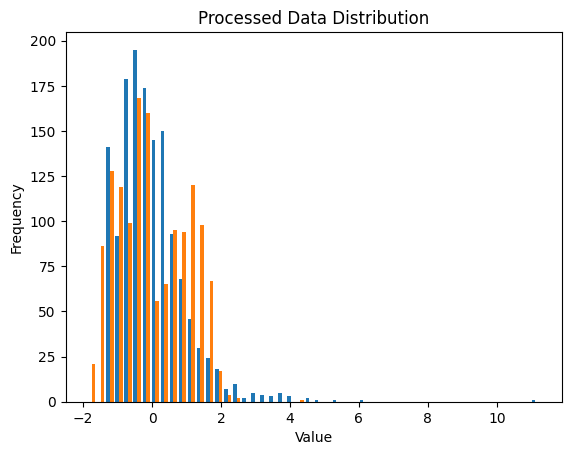

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 2.9 K  | train
1 | decoder | Sequential | 2.7 K  | train
-----------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
C:\Users\amin\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 186.44it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 185.65it/s]


2024-12-02 09:58:39,009 - INFO - VAEAlgorithm - Anomaly detection threshold set at: 0.2322475165128708


In [34]:
# Initialize VAE Algorithm
vae_algorithm = VAEAlgorithm()
data_processed = vae_algorithm.process_data(data)
plt.hist(data_processed, bins=50)
plt.title('Processed Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Train Model
vae_algorithm.train_model(data_processed)

## Detect Anomalies
Run the trained model to identify anomalies and visualize the results.

2024-12-02 09:58:40,394 - INFO - VAEAlgorithm - VAEAlgorithm - detect_anomalies method invoked
2024-12-02 09:58:40,404 - INFO - VAEAlgorithm - Anomalies detected: 56


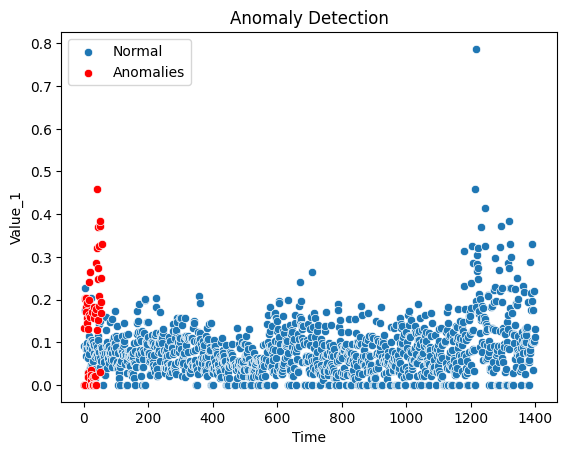

In [35]:
# Detect anomalies
anomalies = vae_algorithm.detect_anomalies(data, data)
sns.scatterplot(data=data, x=data.index, y='value_1', label='Normal')
sns.scatterplot(data=anomalies, x=anomalies.index, y='value_1', color='red', label='Anomalies')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value_1')
plt.legend()
plt.show()

## Model Evaluation
Assess model reconstruction probability and visualize thresholds.

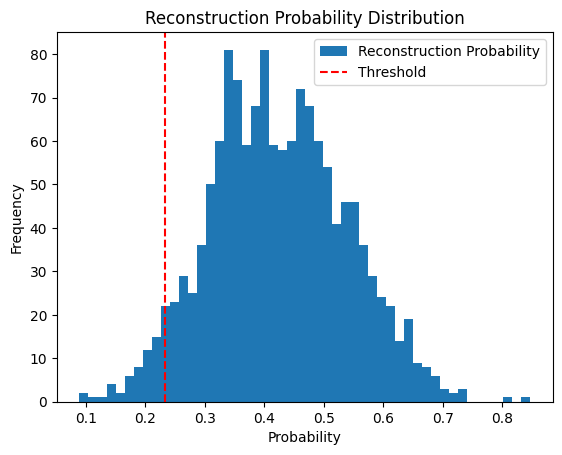

In [36]:
# Reconstruction probability
with torch.no_grad():
    recon_prob = vae_algorithm.model.reconstructed_probability(torch.tensor(data_processed))
plt.hist(recon_prob.numpy(), bins=50, label='Reconstruction Probability')
plt.axvline(x=vae_algorithm.threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()